# Part 3: Single-View Geometry

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the *Single-View Geometry* section of Assignment 3. In [main function](#Main-function), we outline the required functionalities step by step. Some of the functions which involves interactive plots are already provided, but [the rest](#Your-implementation) are left for you to implement.

## Package installation
- In this code, we use `tkinter` package. Installation instruction can be found [here](https://anaconda.org/anaconda/tk).

https://docs.google.com/document/d/1XGz3TRmUyCmiir-a0HlyhhjtoGLYDhm7ruh8a04DmgM/edit

# Common imports

In [2]:
%matplotlib tk
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# Provided functions

In [3]:
def get_input_lines(im, min_lines=3):
    """
    Allows user to input line segments; computes centers and directions.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        min_lines: minimum number of lines required
    Returns:
        n: number of lines from input
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        centers: np.ndarray of shape (3, n)
            where each column denotes the homogeneous coordinates of the centers
    """
    n = 0
    lines = np.zeros((3, 0))
    centers = np.zeros((3, 0))

    plt.figure()
    plt.imshow(im)
    plt.show()
    print('Set at least %d lines to compute vanishing point' % min_lines)
    while True:
        print('Click the two endpoints, use the right key to undo, and use the middle key to stop input')
        clicked = plt.ginput(2, timeout=0, show_clicks=True)
        if not clicked or len(clicked) < 2:
            if n < min_lines:
                print('Need at least %d lines, you have %d now' % (min_lines, n))
                continue
            else:
                # Stop getting lines if number of lines is enough
                break

        # Unpack user inputs and save as homogeneous coordinates
        pt1 = np.array([clicked[0][0], clicked[0][1], 1])
        pt2 = np.array([clicked[1][0], clicked[1][1], 1])
        # Get line equation using cross product
        # Line equation: line[0] * x + line[1] * y + line[2] = 0
        line = np.cross(pt1, pt2)
        lines = np.append(lines, line.reshape((3, 1)), axis=1)
        # Get center coordinate of the line segment
        center = (pt1 + pt2) / 2
        centers = np.append(centers, center.reshape((3, 1)), axis=1)

        # Plot line segment
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')

        n += 1

    return n, lines, centers

In [4]:
def plot_lines_and_vp(im, lines, vp):
    """
    Plots user-input lines and the calculated vanishing point.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        vp: np.ndarray of shape (3, )
    """
    bx1 = min(1, vp[0] / vp[2]) - 10
    bx2 = max(im.shape[1], vp[0] / vp[2]) + 10
    by1 = min(1, vp[1] / vp[2]) - 10
    by2 = max(im.shape[0], vp[1] / vp[2]) + 10

    plt.figure()
    plt.imshow(im)
    for i in range(lines.shape[1]):
        if lines[0, i] < lines[1, i]:
            pt1 = np.cross(np.array([1, 0, -bx1]), lines[:, i])
            pt2 = np.cross(np.array([1, 0, -bx2]), lines[:, i])
        else:
            pt1 = np.cross(np.array([0, 1, -by1]), lines[:, i])
            pt2 = np.cross(np.array([0, 1, -by2]), lines[:, i])
        pt1 = pt1 / pt1[2]
        pt2 = pt2 / pt2[2]
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g')

    plt.plot(vp[0] / vp[2], vp[1] / vp[2], 'ro')
    plt.show()
    print("vp pixel:",vp[0] / vp[2], vp[1] / vp[2])

In [5]:
def get_top_and_bottom_coordinates(im, obj):
    """
    For a specific object, prompts user to record the top coordinate and the bottom coordinate in the image.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        obj: string, object name
    Returns:
        coord: np.ndarray of shape (3, 2)
            where coord[:, 0] is the homogeneous coordinate of the top of the object and coord[:, 1] is the homogeneous
            coordinate of the bottom
    """
    plt.figure()
    plt.imshow(im)

    print('Click on the top coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x1, y1 = clicked[0]
    # Uncomment this line to enable a vertical line to help align the two coordinates
    # plt.plot([x1, x1], [0, im.shape[0]], 'b')
    print('Click on the bottom coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x2, y2 = clicked[0]

    plt.plot([x1, x2], [y1, y2], 'b')

    return np.array([[x1, x2], [y1, y2], [1, 1]])

# Your implementation

In [6]:
def get_vanishing_point(n, lines):
    """
    Solves for the vanishing point using the user-input lines.
    Inputs:
        n: number of lines from input
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        centers: np.ndarray of shape (3, n)
            where each column denotes the homogeneous coordinates of the centers
    Return:
        vp: np.ndarray of shape (3, 1)
    """
    # <YOUR IMPLEMENTATION>
    p = []
    for i in range(n):
        for j in range(i+1,n):
            p.append(np.cross(lines[:,i], lines[:,j]))
    p = np.array(p)
    vp = np.average(p,axis=0)

    print(vp)
    return vp.T

def get_horizon_line(vpts):
    """
    Calculates the ground horizon line.
    Returns:
        a,b,c: np.ndarray of shape ( , 3)
            where ax+by+c=0
    """
    # <YOUR IMPLEMENTATION>
    for i in range(vpts.shape[1]):
        for j in range(i+1, vpts.shape[1]):
            line = np.cross(vpts[:,i], vpts[:,j])
            # print(abs(line[1]/line[0]))
            if abs(line[0]/line[1]) < 1:
                square_rt = np.sqrt(line[0]**2 + line[1]**2)
                return np.array([line[0]/square_rt, line[1]/square_rt, line[2]/square_rt])
            
def plot_horizon_line(im, line):
    """
    Plots the horizon line.
    """
    # <YOUR IMPLEMENTATION>
    print("Horizon line: ", line)
    x = np.linspace(-10, im.shape[1]+10, 10)
    y = (-line[0]*x - line[2])/line[1]
    plt.figure()
    plt.imshow(im)
    plt.plot(x,y, 'b')
    plt.show()

def get_camera_parameters(vpts):
    """
    Computes the camera parameters. Hint: The SymPy package is suitable for this.
    vi.T K.-T K.-1 vj = 0
    K = f 0 u
        0 f v
        0 0 1
    """
    # <YOUR IMPLEMENTATION>
    import sympy as sy
    f, u, v = sy.symbols('f u v',negative=False)
    K = sy.Matrix([ [f, 0, u],
                    [0, f, v],
                    [0, 0, 1]])
    v_pixel=np.zeros(vpts.shape)
    for i in range(3):
        vp = vpts[:,i]
        if vp[2]!=0:
            v_pixel[:,i] = np.array([vp[0] / vp[2], vp[1] / vp[2], 1])
        else:
            v_pixel[:,i] = np.array([vp[0] , vp[1] , 0])
    v0 = v_pixel[:,0]
    v1 = v_pixel[:,1]
    v2 = v_pixel[:,2]
    # print(v0,v1,v2)
    # test = v1.T.dot((K**-1).T).dot(K**-1).dot(v2)
    # print(test)
    s = sy.solve( (v2.T.dot((K**-1).T).dot(K**-1).dot(v1),
                   v2.T.dot((K**-1).T).dot(K**-1).dot(v0),
                   v0.T.dot((K**-1).T).dot(K**-1).dot(v1),
                   v0.T.dot((K**-1).T).dot(K**-1).dot(v2),
                   v1.T.dot((K**-1).T).dot(K**-1).dot(v2),
                   v1.T.dot((K**-1).T).dot(K**-1).dot(v0)),  f,u,v)[0]
    # print(s)
    return s, np.array([v0,v1,v2]).T


def get_rotation_matrix(vpts, f,u,v):
    """
    Computes the rotation matrix using the camera parameters.
    """
    # <YOUR IMPLEMENTATION>
    import sympy as sy
    K = sy.Matrix([ [f, 0, u],
                    [0, f, v],
                    [0, 0, 1]])
    R = (K**-1) @ vpts
    return R

def plotHeight(lines):
    for i, line in enumerate(lines):
        x = np.linspace(-10, im.shape[1]+10, 10)
        y = (-line[0]*x - line[2])/line[1]
        if i==0:
            plt.plot(x,y, 'b')
        else:
            plt.plot(x,y, 'g')

In [7]:
def estimate_height(im, vz, horizon_line, obj_coord, person_coord):
    """
    Estimates height for a specific object using the recorded coordinates. You might need to plot additional images here for
    your report.
    """
    # <YOUR IMPLEMENTATION>
    import math
    # build line Bb connect bottom coord of obj and person
    r = person_coord[:,0]
    b = person_coord[:,1]
    t0 = obj_coord[:,0]
    b0 = obj_coord[:,1]
    vz = vz/vz[2]

    Bb = np.cross(b0,b)

    # find V, the intersect point of bottom line and horizon
    v = np.cross(Bb, horizon_line)
    v = v/v[2]

    # t = np.cross(np.cross(v,r), np.cross(obj_coord[:,0],obj_coord[:,1]))

    # build line VT, connect V and top of obj
    vt = np.cross(v, t0)

    # build line ref, which is the vertical line of the person
    ref = np.cross(r, vz)
    # find the intersect h between object top line and ref vertical line
    t = np.cross(vt, ref)
    t = t/t[2]

    # use cross ratio to estimate the height

    # H = 1.75*(np.linalg.norm(t-b)*np.linalg.norm(vz-r))/(np.linalg.norm(r-b)*np.linalg.norm(vz-t))
    H = 1.75*(math.dist(t,b)*math.dist(vz,r))/(math.dist(r,b)*math.dist(vz,t))

    plt.figure()
    plt.imshow(im)
    plt.ylim(bottom=im.shape[0], top=0)
    plotHeight([horizon_line, Bb, vt, ref])
    plt.plot([v[0], r[0]], [v[1], r[1]], color='b')
    plt.show()
    return H
# estimate_height(im, vpts[:,2], horizon_line, coords['the lamp posts'], coords['person'])

# Main function

In [8]:
im = np.asarray(Image.open('CSL.jpeg'))

# Part 1
# Get vanishing points for each of the directions
num_vpts = 3
vpts = np.zeros((3, num_vpts))
for i in range(num_vpts):
    print('Getting vanishing point %d' % i)
    # Get at least three lines from user input
    n, lines, centers = get_input_lines(im)
    # <YOUR IMPLEMENTATION> Solve for vanishing point
    vpts[:, i] = get_vanishing_point(n, lines)
    # Plot the lines and the vanishing point
    plot_lines_and_vp(im, lines, vpts[:, i])


Getting vanishing point 0
Set at least 3 lines to compute vanishing point
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
[-586371.53259497  397641.96317873    1883.67886931]
vp pixel: -311.2906038003344 211.09859523101883
Getting vanishing point 1
Set at least 3 lines to compute vanishing point
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right 

C:\Users\fiona\AppData\Local\Temp\ipykernel_19560\4272106865.py:24: RuntimeWarning: divide by zero encountered in true_divide
  pt1 = pt1 / pt1[2]
C:\Users\fiona\AppData\Local\Temp\ipykernel_19560\4272106865.py:24: RuntimeWarning: invalid value encountered in true_divide
  pt1 = pt1 / pt1[2]
C:\Users\fiona\AppData\Local\Temp\ipykernel_19560\4272106865.py:25: RuntimeWarning: divide by zero encountered in true_divide
  pt2 = pt2 / pt2[2]
C:\Users\fiona\AppData\Local\Temp\ipykernel_19560\4272106865.py:25: RuntimeWarning: invalid value encountered in true_divide
  pt2 = pt2 / pt2[2]


Horizon line:  [ 1.22987013e-02 -9.99924368e-01  2.14911100e+02]


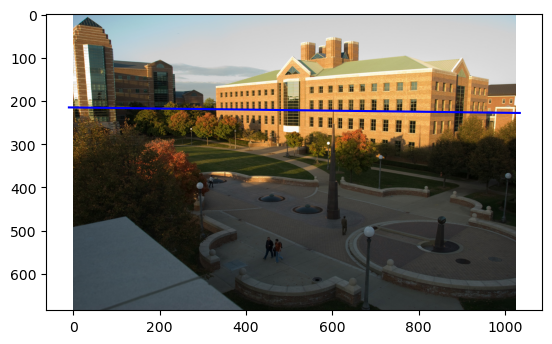

[ 1.22987013e-02 -9.99924368e-01  2.14911100e+02]
792.347422749073 626.124404038656 311.015504206119
Matrix([[-1.18308582942896, 0.856014937739979, -0.110260285140200], [-0.126102396633582, -0.101022208615968, 8.96451939912713], [1.00000000000000, 1.00000000000000, 1.00000000000000]])


In [9]:
# <YOUR IMPLEMENTATION> Get the ground horizon line
horizon_line = get_horizon_line(vpts)
# <YOUR IMPLEMENTATION> Plot the ground horizon line
%matplotlib inline
plot_horizon_line(im,horizon_line)
print(horizon_line)
%matplotlib tk
# Part 2
# <YOUR IMPLEMENTATION> Solve for the camera parameters (f, u, v)
(f, u, v), vps = get_camera_parameters(vpts)
print(f, u, v)

# Part 3
# <YOUR IMPLEMENTATION> Solve for the rotation matrix
R = get_rotation_matrix(vps, f, u, v)
print(R)



In [10]:
# Part 4
# Record image coordinates for each object and store in map
objects = ('person', 'CSL building', 'the spike statue', 'the lamp posts')
coords = dict()
for obj in objects:
    coords[obj] = get_top_and_bottom_coordinates(im, obj)

Click on the top coordinate of person
Click on the bottom coordinate of person
Click on the top coordinate of CSL building
Click on the bottom coordinate of CSL building
Click on the top coordinate of the spike statue
Click on the bottom coordinate of the spike statue
Click on the top coordinate of the lamp posts
Click on the bottom coordinate of the lamp posts


In [11]:
# <YOUR IMPLEMENTATION> Estimate heights
# print(coords)
# coords['person'] = np.array([[626,625],[464,511],[1,1]])
# coords['CSL building'] = np.array([[472 , 475],[152, 305],[1,1]])
# coords['the spike statue'] = np.array([[602 , 600],[190, 474],[1,1]])
# coords['the lamp posts'] = np.array([[590, 590],[295,356],[1,1]])
for obj in objects[1:]:
    print('Estimating height of %s' % obj)
    height = estimate_height(im, vpts[:,2], horizon_line, coords[obj], coords['person'])
    print(height, "m")

Estimating height of CSL building
19.47183677772831 m
Estimating height of the spike statue
12.5723239978811 m
Estimating height of the lamp posts
5.3456319929420655 m
